In [59]:
import logging
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.utils.callbacks import TFMProgressBar
from tqdm.auto import tqdm

In [60]:
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import MissingValuesFiller, Scaler

In [61]:
logging.disable(logging.CRITICAL)
warnings.filterwarnings("ignore")

Check for GPU

In [62]:
torch.cuda.is_available()

True

Utils

In [63]:
def generate_torch_kwargs():
    # run torch models on device, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "gpu",
            "devices": [0],
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

Custom imports

In [64]:
# Adicionar a pasta 'src' ao caminho do sistema
sys.path.append(os.path.abspath(os.path.join("..", "src")))

# Agora você pode importar o módulo utils Ou importar funções específicas do módulo
from ts_plots import plot_forecast
from utils import convert_dfs_to_ts, preprocess_list_ts, separate_by_uid_and_frequency

Params

In [65]:
H = 10  # Tamanho da janeça de previsão
K = 5 * H  # Tamanho da janela de entrada

Load Static and Mobile Dataset

In [66]:
checkpoints_path = os.path.join(os.pardir, "checkpoints")

In [67]:
df_static = pd.read_parquet(os.path.join(checkpoints_path, "5G_df_static.parquet.gzip"))
df_driving = pd.read_parquet(
    os.path.join(checkpoints_path, "5G_df_driving.parquet.gzip")
)

Split in Streaming vs Downloading

In [68]:
list_static_strm = df_static.query("User_Activity == 'Streaming Video'")
list_driving_strm = df_driving.query("User_Activity == 'Streaming Video'")
list_static_down = df_static.query("User_Activity == 'Downloading a File'")
list_driving_down = df_driving.query("User_Activity == 'Downloading a File'")

Training per unique uid

In [69]:
target_columns = ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]

In [70]:
list_static_strm = separate_by_uid_and_frequency(list_static_strm, target_columns, "S")
list_driving_strm = separate_by_uid_and_frequency(
    list_driving_strm, target_columns, "S"
)
list_static_down = separate_by_uid_and_frequency(list_static_down, target_columns, "S")
list_driving_down = separate_by_uid_and_frequency(
    list_driving_down, target_columns, "S"
)

Convert list to TimeSeries for Training

In [71]:
list_static_strm = convert_dfs_to_ts(list_static_strm, target_columns)
list_driving_strm = convert_dfs_to_ts(list_driving_strm, target_columns)
list_static_down = convert_dfs_to_ts(list_static_down, target_columns)
list_driving_down = convert_dfs_to_ts(list_driving_down, target_columns)

<Axes: xlabel='Timestamp'>

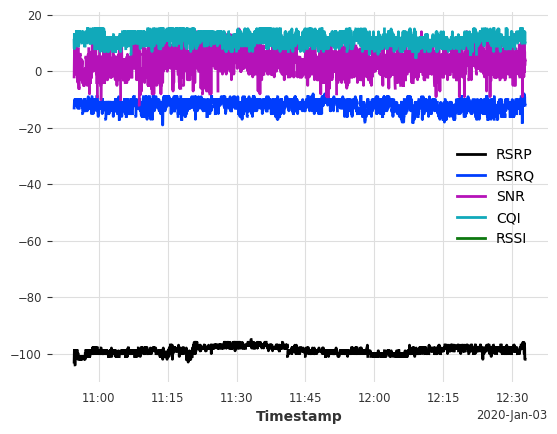

In [72]:
list_static_strm[0].plot()

In [73]:
list_static_strm[0][:-H]

<TimeSeries (DataArray) (Timestamp: 5879, component: 5, sample: 1)> Size: 235kB
array([[[-103.],
        [ -13.],
        [  -2.],
        [  11.],
        [  nan]],

       [[-102.],
        [ -12.],
        [   0.],
        [   8.],
        [  nan]],

       [[-102.],
        [ -12.],
        [   0.],
        [   8.],
        [  nan]],

       ...,

       [[ -98.],
        [  -8.],
        [  11.],
        [  14.],
        [  nan]],

       [[-100.],
        [ -12.],
        [   0.],
        [  12.],
        [  nan]],

       [[-100.],
        [ -12.],
        [   0.],
        [  12.],
        [  nan]]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 47kB 2020-01-03T10:54:39 ... 2020-0...
  * component  (component) object 40B 'RSRP' 'RSRQ' 'SNR' 'CQI' 'RSSI'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [74]:
list_static_strm[0][-H:]

<TimeSeries (DataArray) (Timestamp: 10, component: 5, sample: 1)> Size: 400B
array([[[ -97.],
        [ -11.],
        [   0.],
        [  13.],
        [  nan]],

       [[  nan],
        [  nan],
        [  nan],
        [  nan],
        [  nan]],

       [[ -97.],
        [ -11.],
        [   0.],
        [  13.],
        [  nan]],

       [[ -98.],
        [  -9.],
...
        [  14.],
        [  nan]],

       [[-102.],
        [ -12.],
        [   4.],
        [  10.],
        [  nan]],

       [[-102.],
        [ -12.],
        [   4.],
        [  10.],
        [  nan]],

       [[-102.],
        [ -12.],
        [   4.],
        [  10.],
        [  nan]]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 80B 2020-01-03T12:32:38 ... 2020-01...
  * component  (component) object 40B 'RSRP' 'RSRQ' 'SNR' 'CQI' 'RSSI'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

___

In [75]:
import time

In [76]:
def collect_metrics(list_series, model_name, model, output_file, K, H):
    if model_name is None:
        model_name = type(model).__name__

    # Aplica o pré-processamento com filler e scaler
    filler = MissingValuesFiller()  # Preenche valores ausentes
    scaler = Scaler()  # Escalona os dados
    pipe = Pipeline([filler, scaler])

    # Armazenar resultados
    result_record = []
    actuals = []
    preds = []
    # TODO: Adicionar indicador em log de onde que está a série.
    for i, series in enumerate(list_series):
        start_time = time.time()
        # Train_Test_Split
        ts_train, ts_test = series[:-H], series[-H:]

        # Transformar a série temporal completa
        ts_train_transformed = pipe.fit_transform(ts_train)

        # Treinar o modelo com a série temporal transformada
        model.fit(ts_train_transformed)

        # Fazer previsões na escala transformada
        y_pred = model.predict(len(ts_test))

        # Se as predições não forem nulas e houver valores suficientes
        if y_pred is not None and len(y_pred) > 0:
            actuals.append(ts_test)
            preds.append(scaler.inverse_transform(y_pred))

        # Extrair os dados e o índice de tempo da série temporal transformada
        # data = ts_transformed.values()
        # times = ts_transformed.time_index

        # results = sliding_window_cross_validate_and_evaluate(
        #     model, series[kpi], K, H, 60, model_name
        # )
        elapsed_time = time.time() - start_time
        results = {
            "Time_Index": ts_test.time_index.values,
            "Model": model_name,
            "Actuals": actuals,
            "Preds": preds,
            "ElapsedTime": elapsed_time,
        }
        result_record.append(results)

    result_record = pd.DataFrame(result_record)

    _path = os.path.join(checkpoints_path, "results", output_file)
    result_record.to_parquet(_path, compression="gzip")
    print(f"Saved in {_path}")
    return result_record

In [77]:
all_stats = []

# N-BEATS

In [78]:
model_name = "NBEATS"
model_NBEATS = NBEATSModel(
    input_chunk_length=K,
    output_chunk_length=H,
    n_epochs=100,
    random_state=None,
    **generate_torch_kwargs()
)

In [79]:
activity = "static_strm"
output_file = f"global_{model_name}_{activity}.gzip"

In [80]:
result = collect_metrics(list_static_strm, model_name, model_NBEATS, output_file, K, H)

Epoch 88:  24%|██▍       | 49/202 [00:08<00:27,  5.58it/s, train_loss=nan.0]       